# The aim of this notebooks is to provide basic exploratory data analysis

In [1]:
# Basic Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Statistical libraries
from scipy import stats
from statsmodels.graphics import tsaplots

# utilities
import sys
import nltk
sys.path.append('modules')
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kotakikuchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Basic Environment setup
plt.rcParams['figure.figsize'] = (15,5)

# Make pandas display all columns
pd.set_option("display.max_columns", None)

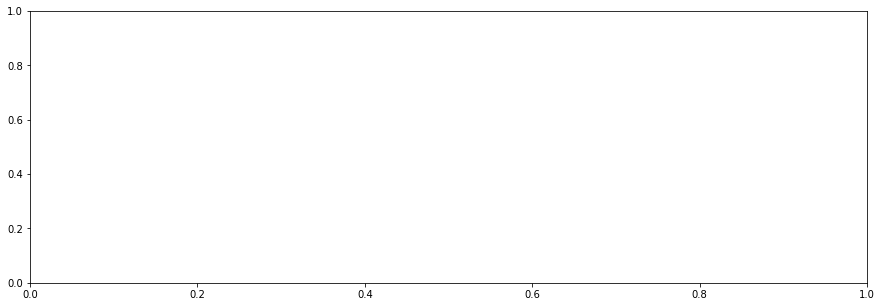

In [3]:
fig,ax=plt.subplots()

rect = fig.patch
rect.set_facecolor("white")

## Downloading Data

In [4]:
bitcoin = utils.get_data('BTCUSDT', exchange = 'BINANCE',start_date = "2020-01-01", end_date = '2021-12-31')

twitter_sentiment = pd.read_pickle('../data/cleaned/by_date_verified_weighted_sentiment_2020-2021.pkl')
twitter_price_opinion = pd.read_pickle('../data/cleaned/by_date_verified_weighted_money_2020-2021.pkl')
twitter_price_opinion_normalized =  pd.read_pickle('../data/cleaned/by_date_normalized_money_2020-2021.pkl')
twitter_price_opinion_normalized['created_at'] = pd.to_datetime(twitter_price_opinion_normalized['created_at'])

# merging the data based on datetime with how = 'outer' as we would like to cover all the dates during 2020-2021 .
merged_df = bitcoin.merge(twitter_sentiment, how = 'outer', left_on = 'datetime', right_on = 'created_at').drop(columns = 'created_at')\
            .merge(twitter_price_opinion_normalized, how = 'outer', left_on = 'datetime', right_on = 'created_at')



you are using nologin method, data you access may be limited


In [5]:
print(f"N rows bitcoin: {len(bitcoin)}")
print(f"N rows twitter_sentiment: {len(twitter_sentiment)}")
print(f"N rows twitter_price_opinion: {len(twitter_price_opinion)}")
print(f"N rows twitter_price_opinion_normalized: {len(twitter_price_opinion_normalized)}")
print(f"N rows merged_df: {len(merged_df)}")

N rows bitcoin: 731
N rows twitter_sentiment: 731
N rows twitter_price_opinion: 731
N rows twitter_price_opinion_normalized: 724
N rows merged_df: 731


In [7]:
merged_df.head()

,datetime,symbol,open,high,low,close,volume,weighted_sentiment,created_at,normalized_money
0,2020-01-01,BINANCE:BTCUSDT,7200.77,7212.50,6924.74,6965.71,31951.483932,0.126772,2020-01-01,-1.732184
1,2020-01-02,BINANCE:BTCUSDT,6965.49,7405.00,6871.04,7344.96,68428.500451,0.073418,2020-01-02,-2.153626
2,2020-01-03,BINANCE:BTCUSDT,7345.00,7404.00,7272.21,7354.11,29987.974977,0.145800,2020-01-03,-1.508160
3,2020-01-04,BINANCE:BTCUSDT,7354.19,7495.00,7318.00,7358.75,38331.085604,0.087736,2020-01-04,-2.642491
4,2020-01-05,BINANCE:BTCUSDT,7357.64,7795.34,7346.76,7758.00,54635.695316,0.057072,2020-01-05,-1.754553


## Exploratory Data Analysis

In [10]:
merged_df.describe()

,open,high,low,close,volume,weighted_sentiment,normalized_money
count,802.000000,802.000000,802.000000,802.000000,802.000000,731.000000,724.000000
mean,30255.443354,31135.149988,29260.927805,30295.039825,67839.865502,0.107336,-0.191647
std,19075.733357,19610.704362,18436.658416,19060.812683,38552.897189,0.039101,0.352072
min,4800.010000,5365.420000,3782.130000,4800.000000,289.205330,-0.102528,-2.642491
25%,10021.390000,10268.397500,9736.500000,10130.200000,43794.774650,0.085901,-0.197880
50%,33654.585000,34878.000000,32186.960000,33684.105000,58254.699377,0.110125,-0.091370
75%,47047.102500,48327.445000,45669.562500,47047.110000,82168.351760,0.132507,-0.027582
max,67525.820000,69000.000000,66222.400000,67525.830000,402201.673764,0.220885,0.296493


- We observe that the mean of sentiment is 0.1 and is not 0. In fact, the sentiment is skewed to the left

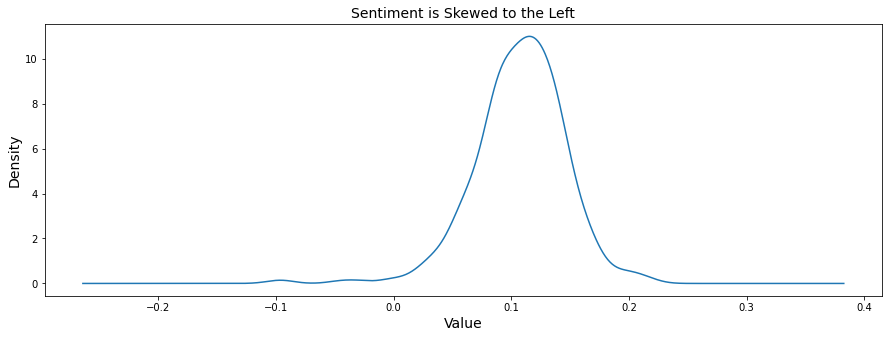

In [8]:

merged_df['weighted_sentiment'].plot.density()

plt.title("Sentiment is Skewed to the Left", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.xlabel("Value", fontsize = 14)

plt.savefig('figures/sentiment_distribution.png', bbox_inches='tight', pad_inches=0.1,facecolor = rect.get_facecolor())



- We observe that price of Bitcoin has historically been increasing withle the trading volume has not.

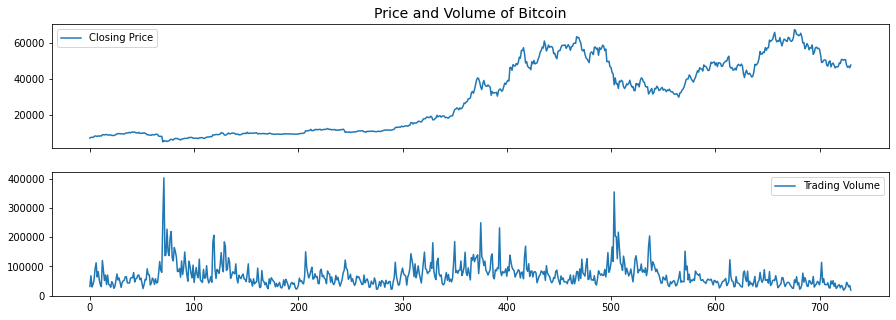

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)

ax1.plot(merged_df['close'], label = "Closing Price")
ax2.plot(merged_df['volume'], label = "Trading Volume")

ax1.set_title("Price and Volume of Bitcoin", fontsize = 14)
ax1.legend()
ax2.legend()

plt.savefig('figures/price_and_volume.png', bbox_inches='tight', pad_inches=0.1,facecolor = rect.get_facecolor())

- Let us check independence of the closing price - clearly, close prices are highly correlated

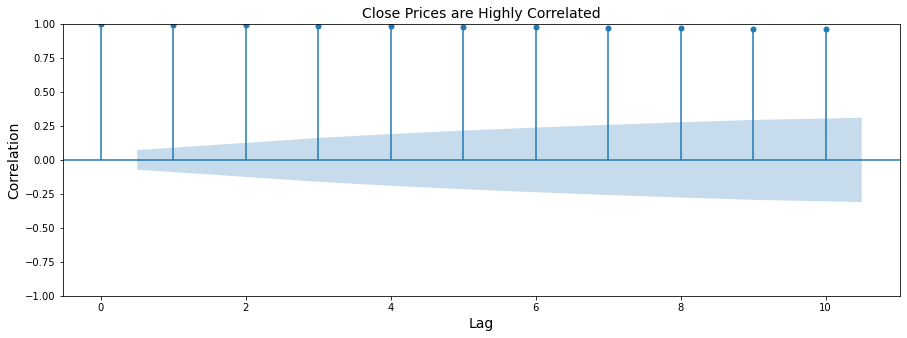

In [10]:
fig = tsaplots.plot_acf(merged_df['close'], lags=10)

plt.title("Close Prices are Highly Correlated",  fontsize = 14)
plt.ylabel("Correlation",  fontsize = 14)
plt.xlabel("Lag",  fontsize = 14)

plt.show()

fig.savefig('figures/autocorrelation.png', bbox_inches='tight', pad_inches=0.1,facecolor = rect.get_facecolor())



- Autocorrelation of returns is significanlty lower for close price return. This is more approriate for linear regressions as the dependent variable is supposed to be independent from one another.

In [11]:
for i in range(1, 10):
    merged_df['close_return_'+str(i)] = utils.calculate_return(merged_df, ['close'], i)['close_return']

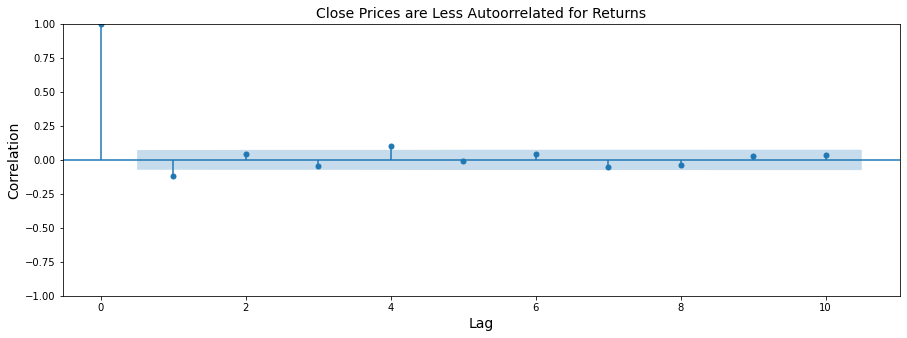

In [12]:


fig = tsaplots.plot_acf(merged_df['close_return_1'].dropna(), lags=10)
plt.title("Close Prices are Less Autoorrelated for Returns",  fontsize = 14)
plt.ylabel("Correlation",  fontsize = 14)
plt.xlabel("Lag",  fontsize = 14)

plt.show()

fig.savefig('figures/autocorrelation_1_day_return.png', bbox_inches='tight', pad_inches=0.1,facecolor = rect.get_facecolor())





- Autocorreltion is much lower in the case of one-day return.

In [13]:
merged_df['close_return_1'].describe()

count    730.000000
mean       0.003514
std        0.041013
min       -0.395048
25%       -0.015468
50%        0.002717
75%        0.022527
max        0.195361
Name: close_return_1, dtype: float64

Text(0.5, 0, 'Value')

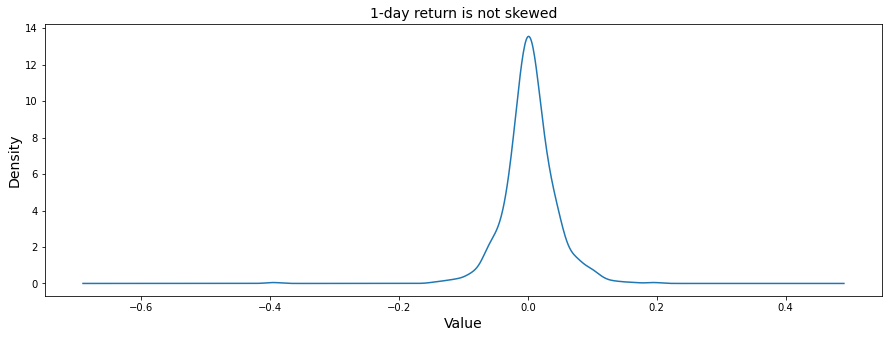

In [14]:
merged_df['close_return_1'].plot.density()

plt.title("1-day return is not skewed", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.xlabel("Value", fontsize = 14)

#plt.savefig('figures/.png', bbox_inches='tight', pad_inches=0.1,facecolor = rect.get_facecolor())